# Regressing Litter on Deprivation in Glasgow City

This notebook performs data manipulation, exploration and analysis using count data regression models.

The objective is to determine whether one or more deprivation factors significantly increases or decreases the amount of litter in areas of Glasgow City.

## Data Preparation

- Read the data from a CSV file.
- Remove unnecessary columns.
- Assign valid data types.
- Impute missing values denoted by "*" with their mean.
- Impute missing values denoted by 0 with their mean.
- Split the data into training (70%), validation (20%) and test (10%) data sets.

In [41]:
import pandas as pd
import numpy as np

# The path to the file containing the deprivation and litter data.
data_fpath = "../data/glasgow-litter-simd2020v2.csv"

def remove_features(df):
  """Remove features from the data that we do not need"""
  columns_to_remove = [
    #"Total_population",
    #"Working_Age_population",
    "SIMD2020v2_Rank",
    "SIMD_2020v2_Percentile",
    "SIMD2020v2_Vigintile",
    "SIMD2020v2_Decile",
    "SIMD2020v2_Quintile",
    "SIMD2020v2_Income_Domain_Rank",
    "SIMD2020_Employment_Domain_Rank",
    "SIMD2020_Health_Domain_Rank",
    "SIMD2020_Education_Domain_Rank",
    "SIMD2020_Access_Domain_Rank",
    "SIMD2020_Crime_Domain_Rank",
    "SIMD2020_Housing_Domain_Rank"
  ]
  return df.drop(columns_to_remove, axis=1)

def impute_missing_data(df):
  """Replace missing values with their mean"""
  features = [
    "Total_population",
    "Working_Age_population",
    "CIF",
    "ALCOHOL",
    "DRUG",
    "SMR",
    "DEPRESS",
    "LBWT",
    "EMERG",
    "Attendance",
    "Attainment",
    "not_participating",
    "University",
    "crime_count",
    "crime_rate",
    "broadband"
  ]
  for f in features:
    df[f].fillna(df[f].mean(), inplace=True)
    df[f].replace(to_replace=0, value=df[f].mean(), inplace=True)
  return df

def impute_data_zones(df):
  """Impute missing values from data zone S01010206 using the zone next to it."""
  features = [
    "Total_population",
    "Working_Age_population",
    "income_rate",
    "income_count",
    "employment_rate",
    "employment_count"
  ]
  for f in features:
    dz1, dz2 = df.loc[df["Data_Zone"] == "S01010206"], df.loc[df["Data_Zone"] == "S01010207"]
    n = df.at[dz2.index[0], f]
    df.at[dz1.index[0], f] = n
  return df

def convert_float_feature_types(df):
  """Convert percentage strings to floats between 0-1"""
  to_float_features = [
    "income_rate",
    "employment_rate",
    "DEPRESS",
    "LBWT",
    "Attendance",
    "not_participating",
    "University",
    "overcrowded_rate",
    "nocentralheating_rate",
    "broadband"
  ]
  # These are not percentages
  df["crime_rate"] = df["crime_rate"].astype(float)
  df["crime_count"] = df["crime_count"].astype(float)
  df["Attainment"] = df["Attainment"].astype(float)
  for f in to_float_features:
    df[f] = df[f].str.rstrip("%").astype(float) / 100
  return df

def standardise_features(df):
  features = [
    "Total_population",
    "Working_Age_population",
    "income_rate",
    "income_count",
    "employment_rate",
    "employment_count",
    "CIF",
    "ALCOHOL",
    "DRUG",
    "SMR",
    "DEPRESS",
    "LBWT",
    "EMERG",
    "Attendance",
    "Attainment",
    "no_qualifications",
    "not_participating",
    "University",
    "drive_petrol",
    "drive_GP",
    "drive_post",
    "drive_primary",
    "drive_retail",
    "drive_secondary",
    "PT_GP",
    "PT_post",
    "PT_retail",
    "broadband",
    "crime_rate",
    "crime_count",
    "overcrowded_count",
    "overcrowded_rate",
    "nocentralheating_count",
    "nocentralheating_rate"
  ]
  sdf = df[features]
  df[features] = (sdf - sdf.mean()) / sdf.std()
  return df

def convert_categorical_feature_types(df):
  """Convert strings to categorical features"""
  to_category_features = [
    "Data_Zone",
    "Intermediate_Zone",
    "Council_area"
  ]
  for f in to_category_features:
    df[f] = df[f].astype("category")
  return df

def convert_feature_types(df):
  """Convert features to the correct types"""
  df = df.replace("*", np.NaN)
  df = convert_float_feature_types(df)
  return convert_categorical_feature_types(df)

def read_data_from_file(fpath):
  """Read the data from file, handle missing data and assign feature types"""
  df = pd.read_csv(fpath, header=0)
  df = remove_features(df)
  df = convert_feature_types(df)
  df = impute_missing_data(df)
  #df = standardise_features(df)
  return df

def split_data(df, valid_frac=0.2, test_frac=0.1, random_state=1):
  """Split into train/valid/test data (default 70%/20%/10%)"""
  train_frac = 1 - valid_frac - test_frac
  return np.split(
    df.sample(frac=1, random_state=random_state),
    [int(train_frac * len(df)), int((train_frac + valid_frac) * len(df))],
  )

def get_split_data(random_state=None):
  """Get a dataframe of the data split into train/valid/test (70%/20%/10%)"""
  df = read_data_from_file(data_fpath)
  return split_data(df, random_state=random_state)

View how many observations we have in each data set:

In [42]:
df_train, df_valid, df_test = get_split_data()

print("Training data: {} observations".format(len(df_train)))
print("Validation data: {} observations".format(len(df_valid)))
print("Test data: {} observations".format(len(df_test)))

Training data: 522 observations
Validation data: 149 observations
Test data: 75 observations


Verify that the factor data types are correct and that there are no missing values:

In [43]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522 entries, 293 to 659
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Data_Zone               522 non-null    category
 1   Intermediate_Zone       522 non-null    category
 2   Council_area            522 non-null    category
 3   Total_population        522 non-null    float64 
 4   Working_Age_population  522 non-null    float64 
 5   income_rate             522 non-null    float64 
 6   income_count            522 non-null    int64   
 7   employment_rate         522 non-null    float64 
 8   employment_count        522 non-null    int64   
 9   CIF                     522 non-null    float64 
 10  ALCOHOL                 522 non-null    float64 
 11  DRUG                    522 non-null    float64 
 12  SMR                     522 non-null    float64 
 13  DEPRESS                 522 non-null    float64 
 14  LBWT                    

In [44]:
df_train.isnull().sum()

Data_Zone                 0
Intermediate_Zone         0
Council_area              0
Total_population          0
Working_Age_population    0
income_rate               0
income_count              0
employment_rate           0
employment_count          0
CIF                       0
ALCOHOL                   0
DRUG                      0
SMR                       0
DEPRESS                   0
LBWT                      0
EMERG                     0
Attendance                0
Attainment                0
no_qualifications         0
not_participating         0
University                0
crime_count               0
crime_rate                0
overcrowded_count         0
nocentralheating_count    0
overcrowded_rate          0
nocentralheating_rate     0
drive_petrol              0
drive_GP                  0
drive_post                0
drive_primary             0
drive_retail              0
drive_secondary           0
PT_GP                     0
PT_post                   0
PT_retail           

## Data Exploration

- Total population ranges between 288 - 2544 per data zone.
- Working age population ranges between 165 - 2361 per data zone.
- On average, 19% are income deprived.
- On average, 14% are employment deprived.
- On average, 21% are prescribed drugs for anxiety, depression or psychosis.
- On average, 7% of births are live singleton or low weight.
- On average, there is a 76% pupil attendance at school.
- On average, the attainment score of school leavers is 5.4.
- On average, 5% of 16 - 19 year olds are not in education, employment or training.
- On average, 8% of 17 - 21 year olds are entering university.
- On average, the comparative illness factor ratio is 152 (100 is Scottish average.)
- On average, the standardised mortality ratio is 121 (100 is Scottish average.)
- On average, the hospital stays related to alcohol misuse ratio is 178 (100 is Scottish average.)
- On average, the hospital stays related to drug misuse ratio is 173 (100 is Scottish average.)
- On average, the emergency hospital stays ratio is 121 (100 is Scottish average.)
- On average, the working age population with no qualifications ratio is 148 (100 is Scottish average.)
- On average, it's a 3.1 minute drive to a petrol station.
- On average, it's a 2.3 minute drive to a GP.
- On average, it's a 7.1 minute journey to a GP via public transport.
- On average, it's a 2.3 minute drive to a post office.
- On average, it's a 7.1 minute journey to a post office via public transport.
- On average, it's a 2.6 minute drive to a primary school.
- On average, it's a 4.2 minute drive to a secondary school.
- On average, it's a 3.5 minute drive to a retail centre.
- On average, it's a 9.5 minute journey to a retail centre via public transport.
- On average, 2% of premises do not have access to superfast broadband.
- On average, there are 440 incidents of crime per 10,000 people.
- On average, 21% are in overcrowded households.
- On average, 3% are in households without central heating.
- Litter ranges between 0 - 58 per data zone.
- On average, there are 10 littered objects per 50 images per data zone.

In [61]:
df_train.describe()

,Total_population,Working_Age_population,income_rate,income_count,employment_rate,employment_count,CIF,ALCOHOL,DRUG,SMR,...,drive_GP,drive_post,drive_primary,drive_retail,drive_secondary,PT_GP,PT_post,PT_retail,broadband,litter
count,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,...,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000
mean,830.966411,586.068989,0.198525,159.467433,0.142395,77.521073,152.284567,178.349081,173.928377,121.782693,...,2.329710,2.368930,2.632230,3.534963,4.243172,7.116069,7.174768,9.679809,0.027698,10.657088
std,237.554449,218.054861,0.121891,102.090472,0.091245,51.023014,71.911548,147.198845,160.875831,51.682404,...,1.001769,0.818668,0.884362,1.302430,1.320535,2.920369,2.537518,3.411845,0.049353,7.891006
min,288.000000,165.000000,0.000000,0.000000,0.000000,0.000000,5.000000,4.000000,7.000000,19.000000,...,0.664751,0.667906,1.056136,0.843476,1.345714,1.595565,1.831674,2.289857,0.010000,0.000000
25%,683.500000,450.250000,0.090000,70.000000,0.060000,33.000000,90.000000,71.250000,58.000000,89.000000,...,1.601258,1.759531,1.999926,2.616532,3.293123,4.970110,5.375621,7.141812,0.015538,5.000000
50%,803.000000,550.000000,0.195000,151.000000,0.130000,68.000000,155.000000,148.000000,151.000000,116.000000,...,2.120453,2.261532,2.498595,3.403915,4.095637,6.784284,6.873669,9.277042,0.015538,9.000000
75%,936.000000,668.750000,0.290000,233.000000,0.210000,111.000000,205.000000,239.000000,228.000000,146.000000,...,2.943168,2.864556,3.092672,4.372244,5.024142,8.782007,8.654184,11.825452,0.015538,14.000000
max,2544.000000,2361.000000,0.510000,546.000000,0.470000,311.000000,340.000000,1656.000000,1575.000000,446.000000,...,5.931633,5.201232,6.935962,7.919768,8.387209,20.046236,16.288734,20.276690,0.490000,58.000000


In [62]:
df_train.head()

,Data_Zone,Intermediate_Zone,Council_area,Total_population,Working_Age_population,income_rate,income_count,employment_rate,employment_count,CIF,...,drive_GP,drive_post,drive_primary,drive_retail,drive_secondary,PT_GP,PT_post,PT_retail,broadband,litter
293,S01010051,Parkhead West and Barrowfield,Glasgow City,812.0,547.0,0.34,275,0.27,143,230.0,...,1.642013,1.280615,1.549082,1.941860,5.538864,4.073403,3.400124,4.873428,0.150000,10
147,S01009905,Strathbungo,Glasgow City,746.0,554.0,0.19,142,0.09,52,100.0,...,2.095874,2.380194,1.621735,2.646889,3.113267,6.718625,7.857230,7.302323,0.030000,14
171,S01009929,Langside,Glasgow City,570.0,347.0,0.06,32,0.03,9,65.0,...,2.152791,2.448317,1.769204,3.969845,3.871991,5.848472,6.611062,12.373697,0.020000,4
27,S01009785,Crookston South,Glasgow City,778.0,517.0,0.30,237,0.20,104,250.0,...,2.440268,2.019560,2.348408,3.734117,5.511424,7.713311,5.814407,11.483502,0.015538,25
635,S01010393,Partick,Glasgow City,988.0,791.0,0.08,77,0.04,35,95.0,...,0.945746,1.818681,2.171438,2.996747,3.191014,2.812508,4.724277,6.840626,0.015538,14


### Correlations

The positive correlations (>= .3) are no_qualifications, income_rate, CIF, employment_rate, EMERG, DEPRESS, SMR and ALCOHOL.

The negative correlations (>= .3) are Attainment and Attendance.

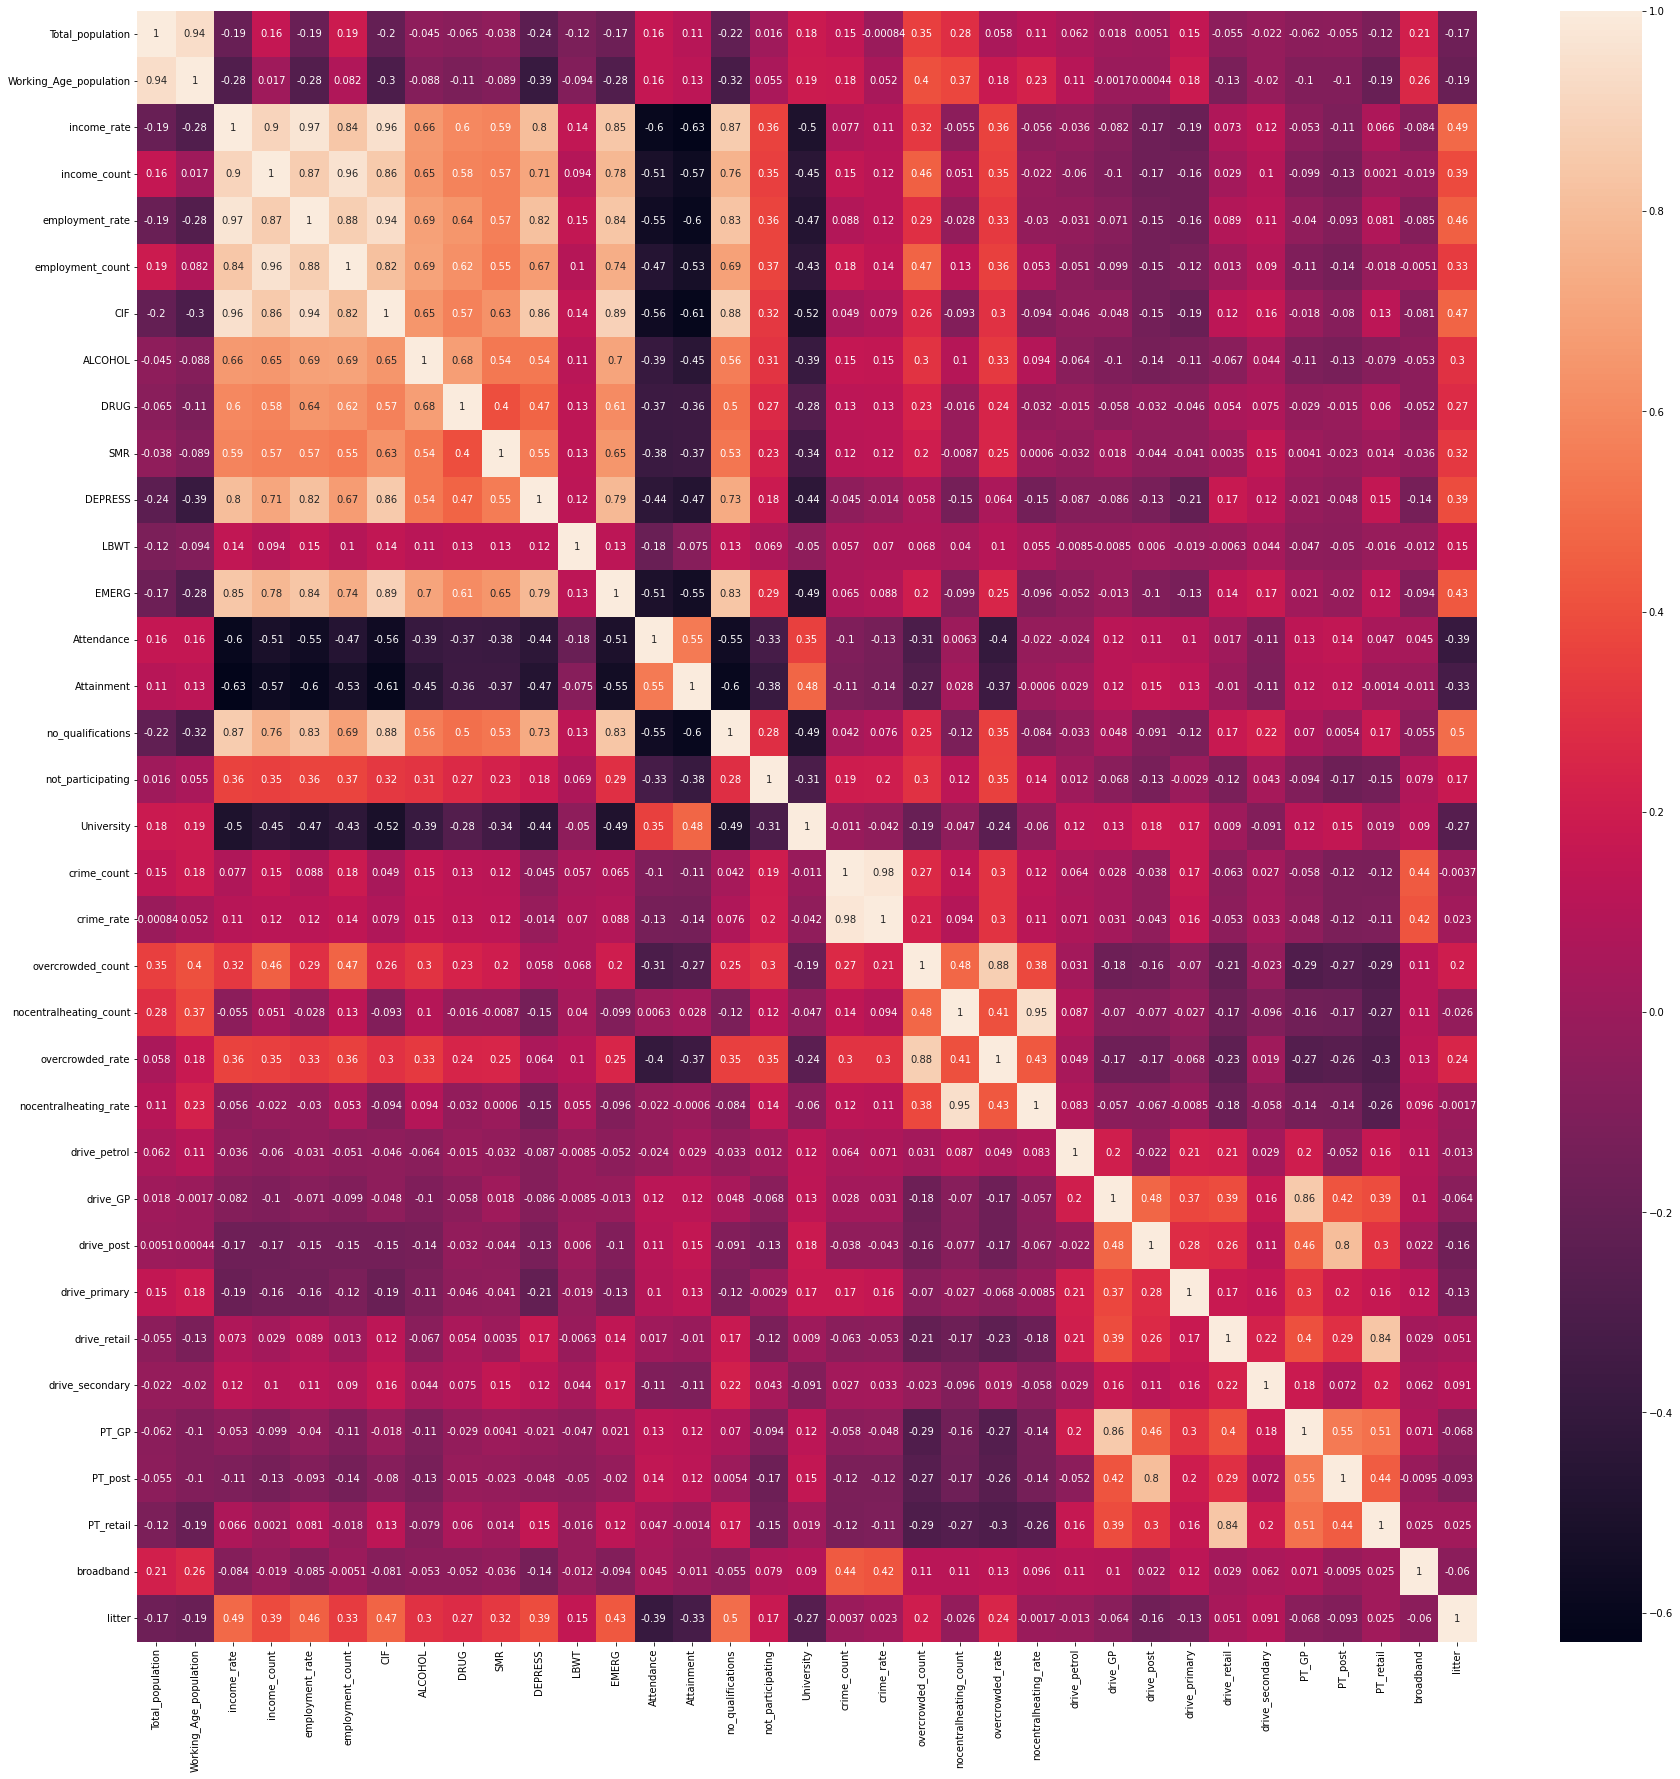

In [80]:
import seaborn as sn
import matplotlib.pyplot as plt

def plot_correlation_matrix(df, columns, figsize=(10,10)):
  plt.figure(figsize=figsize)
  corr_df = pd.DataFrame(df, columns=columns)
  sn.heatmap(corr_df.corr(), annot=True)
  plt.show()

plot_correlation_matrix(df_train, df_train.columns, figsize=(30,30))

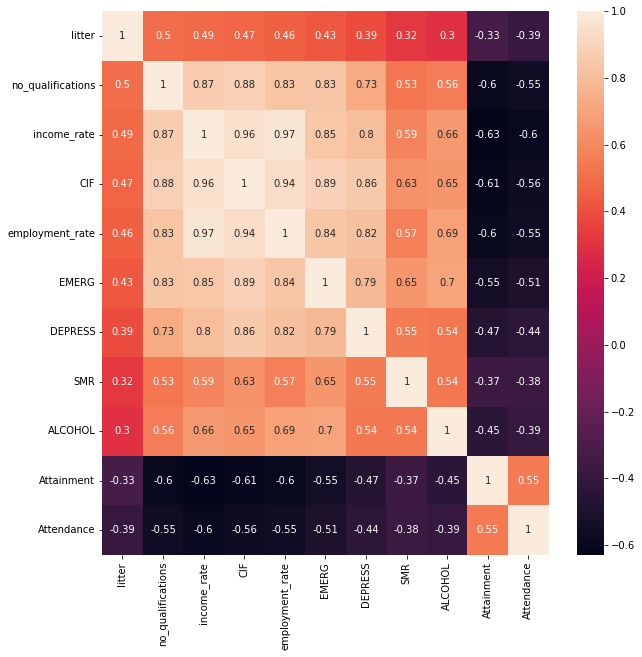

In [79]:
features_with_corr = [
  "litter",
  # Positive
  "no_qualifications",
  "income_rate",
  "CIF",
  "employment_rate",
  "EMERG",
  "DEPRESS",
  "SMR",
  "ALCOHOL",
  # Negative
  "Attainment",
  "Attendance"
]

plot_correlation_matrix(df_train, columns=features_with_corr)

## Visualise

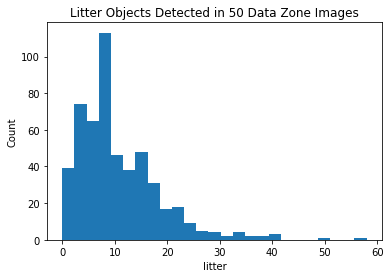

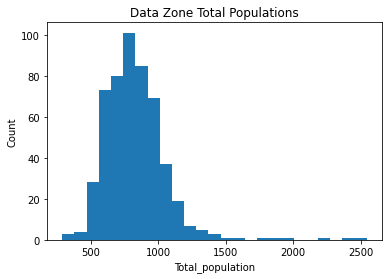

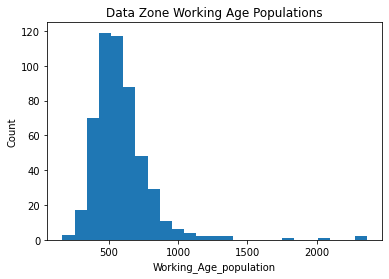

In [84]:
def plot_histogram(column, title, bins=25):
  ax = df_train.hist(column=column, bins=bins, grid=False)
  for x in ax[0]:
    x.set_title(title)
    x.set_xlabel(column)
    x.set_ylabel("Count")

plot_histogram("litter", title="Litter Objects Detected in 50 Data Zone Images")
plot_histogram("Total_population", title="Data Zone Total Populations")
plot_histogram("Working_Age_population", title="Data Zone Working Age Populations")

## Standardise

Standardise the predictors for regression as they are in different units.

In [85]:
df_train = standardise_features(df_train)
df_valid = standardise_features(df_valid)
df_test = standardise_features(df_test)

## Poission

Train a Poisson regression model using forward variable selection.

In [86]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

def forward_selection(df, response, smf_model=smf.poisson, family=sm.families.Poisson()):
    remaining = set(df.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response, ' + '.join(selected + [candidate]))
            model = smf_model(formula, df).fit(method="newton")
            score = model.aic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        print(f"current_score ({current_score}) > best_new_score ({best_new_score})")
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print("Best new score:", best_new_score)
            print("Selected:", selected)
            print("Remaining:", remaining)
            print()
    print("Best score:", best_new_score)
    print("Selected:", selected)
    print("Remaining:", remaining)
    formula = "{} ~ {}".format(response, ' + '.join(selected))
    print("CHOSEN FORMULA: ", formula)
    y_train, X_train = dmatrices(formula, df, return_type="dataframe")
    model = sm.GLM(y_train, X_train, family=family).fit()
    return model

#df_train_in = df_train.drop(["Data_Zone", "Intermediate_Zone", "Council_area"], axis=1)
df_train_in = df_train[features_with_corr]
poisson_model = forward_selection(df_train_in, "litter")

Optimization terminated successfully.
         Current function value: 4.035599
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.284818
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.976518
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.869294
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.104427
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.246006
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.827288
         Iterations 5
Optimization terminated successfully.
         Current function value: 4.345138
         Iterations 6
Optimization terminated successfully.
         Current function value: 4.117649
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.906135
  

In [87]:
print(poisson_model.summary())
print("AIC:", poisson_model.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 litter   No. Observations:                  522
Model:                            GLM   Df Residuals:                      511
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1953.3
Date:                Mon, 14 Mar 2022   Deviance:                       1845.3
Time:                        20:02:07   Pearson chi2:                 1.94e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.8038
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.2891      0.01

The model does not fit as its pearson chi squared value is greater than expected.

In [92]:
from scipy.stats import chi2

def check_pearson_chi2(pearson_chi2, residuals):
  chi_sq = chi2.ppf(.05, df=residuals)
  print("Pearson Chi Sq <= Chi Sq")
  print(f"{pearson_chi2} <= {chi_sq}")
  print(f"The model fits: {pearson_chi2 <= chi_sq}")

check_pearson_chi2(pearson_chi2=poisson_model.pearson_chi2, residuals=poisson_model.df_resid)

Pearson Chi Sq <= Chi Sq
1940.5085465703141 <= 459.5774428416623
The model fits: False


## Negative Binomial

Train a negative binomial regression model using forward variable selection.

In [99]:
nb_model = forward_selection(df_train_in, "litter", smf_model=smf.negativebinomial, family=sm.families.NegativeBinomial(alpha=0.4))

Optimization terminated successfully.
         Current function value: 3.155880
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.209488
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.140143
         Iterations 4
Optimization terminated successfully.
         Current function value: 3.116437
         Iterations 4
Optimization terminated successfully.
         Current function value: 3.178036
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.203181
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.101741
         Iterations 4
Optimization terminated successfully.
         Current function value: 3.217927
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.177366
         Iterations 5
Optimization terminated successfully.
         Current function value: 3.126483
  

The model does fit:

In [100]:
print(nb_model.summary())
print("AIC:", nb_model.aic)
check_pearson_chi2(pearson_chi2=nb_model.pearson_chi2, residuals=nb_model.df_resid)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 litter   No. Observations:                  522
Model:                            GLM   Df Residuals:                      511
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1625.1
Date:                Mon, 14 Mar 2022   Deviance:                       379.20
Time:                        20:03:53   Pearson chi2:                     369.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2733
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.2866      0.03

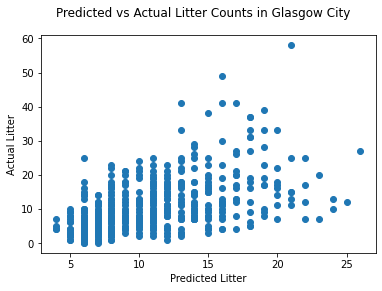

In [102]:
import matplotlib.pyplot as plt

def get_predicted_counts(model, X):
    predictions = model.get_prediction(X)
    df_predictions = predictions.summary_frame()
    return round(df_predictions["mean"])

def scatter_plot(df, formula, model):
    y, X = dmatrices(formula, df, return_type="dataframe")
    predicted_counts, actual_counts = get_predicted_counts(model, X), y["litter"]
    fig = plt.figure()
    fig.suptitle("Predicted vs Actual Litter Counts in Glasgow City")
    plt.scatter(x=predicted_counts, y=actual_counts)
    plt.xlabel("Predicted Litter")
    plt.ylabel("Actual Litter")
    plt.show()

nb_model_formula = "litter ~ ALCOHOL + SMR + Attainment + DEPRESS + EMERG + employment_rate + CIF + Attendance + income_rate + no_qualifications"
scatter_plot(df_train_in, nb_model_formula, nb_model)

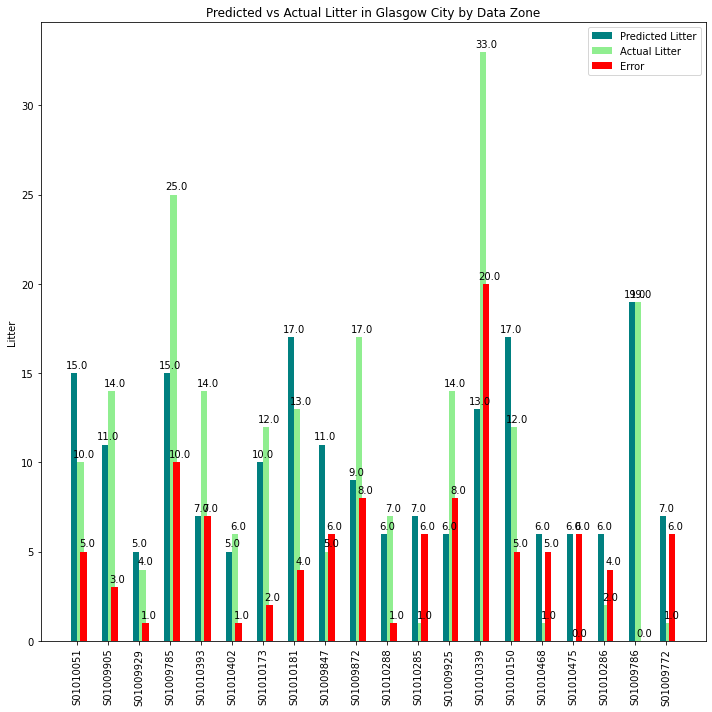

In [116]:
def bar_plot(df, formula, model, n_bars=20, bar_width=0.2):
    y, X = dmatrices(formula, df, return_type="dataframe")
    indices = X.index[:n_bars]
    labels = read_data_from_file(data_fpath).iloc[indices]["Data_Zone"]
    predicted_counts, actual_counts = get_predicted_counts(model, X), y["litter"]
    y_predicted = predicted_counts[:n_bars]
    y_actual = actual_counts[:n_bars]
    y_err = abs(y_predicted - y_actual)

    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    x = np.arange(len(labels))
    rects1 = ax.bar(x - bar_width/2, y_predicted, bar_width, label="Predicted Litter", color="teal")
    rects2 = ax.bar(x + bar_width/2, y_actual, bar_width, label="Actual Litter", color="lightgreen")
    rects3 = ax.bar(x + (bar_width/2) + (bar_width/2), y_err, bar_width, label="Error", color="red")
    ax.set_ylabel("Litter")
    ax.set_title("Predicted vs Actual Litter in Glasgow City by Data Zone")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90)
    ax.legend()
    for rects in [rects1, rects2, rects3]:
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                f"{height}",
                xy=(rect.get_x() + rect.get_width() / 2 + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center", va='bottom'
        )
    fig.tight_layout()
    plt.show()

bar_plot(df_train_in, nb_model_formula, nb_model)

### Validation

Use the validation data set this time.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 litter   No. Observations:                  149
Model:                            GLM   Df Residuals:                      138
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -456.54
Date:                Mon, 14 Mar 2022   Deviance:                       108.94
Time:                        20:07:40   Pearson chi2:                     106.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1325
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.2346      0.05

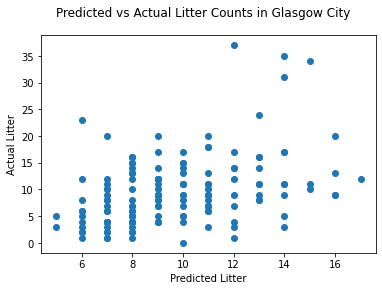

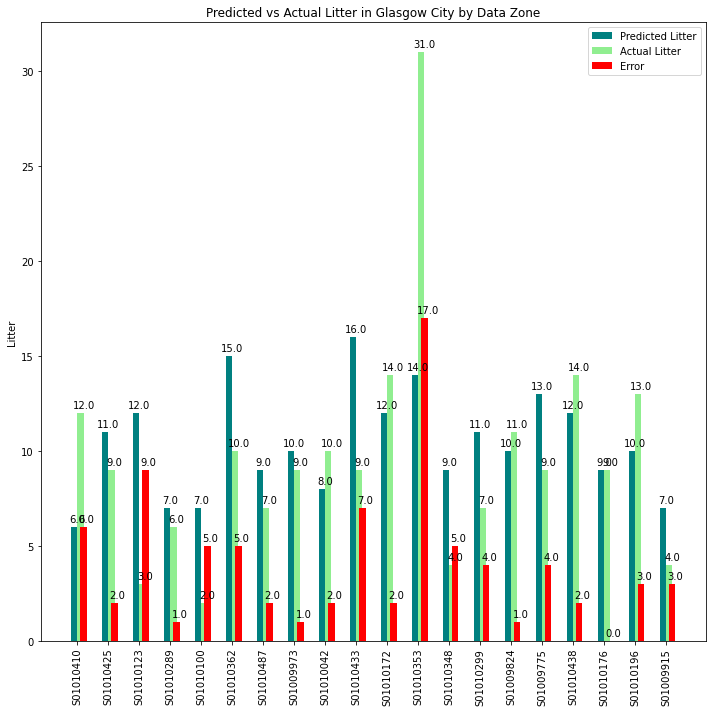

In [118]:
y_valid, X_valid = dmatrices(nb_model_formula, df_valid, return_type="dataframe")
nb_model_valid = sm.GLM(y_valid, X_valid, family=sm.families.NegativeBinomial(alpha=0.4)).fit()
print(nb_model_valid.summary())
print("AIC:", nb_model_valid.aic)
check_pearson_chi2(pearson_chi2=nb_model_valid.pearson_chi2, residuals=nb_model_valid.df_resid)
scatter_plot(df_valid, nb_model_formula, nb_model_valid)
bar_plot(df_valid, nb_model_formula, nb_model_valid)

### Bonferroni Correction

Apply Bonferroni correction to the p-values to account for significant by random chance.

In [119]:
from statsmodels.stats.multitest import multipletests
reject, corrected_pvalues, _, _ = multipletests(nb_model_valid.pvalues, alpha=0.05, method="bonferroni")
print(nb_model_valid.pvalues)
print(corrected_pvalues)
print(reject)

Intercept            0.000000
ALCOHOL              0.866434
SMR                  0.278199
Attainment           0.532488
DEPRESS              0.177953
EMERG                0.284082
employment_rate      0.731110
CIF                  0.209331
Attendance           0.613465
income_rate          0.098189
no_qualifications    0.149430
dtype: float64
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ True False False False False False False False False False False]


### Test

Apply to the test data set.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 litter   No. Observations:                   75
Model:                            GLM   Df Residuals:                       64
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -220.87
Date:                Mon, 14 Mar 2022   Deviance:                       44.777
Time:                        20:09:10   Pearson chi2:                     39.5
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3903
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.1382      0.08

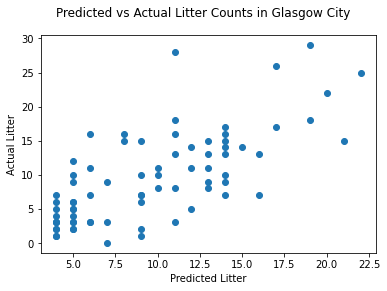

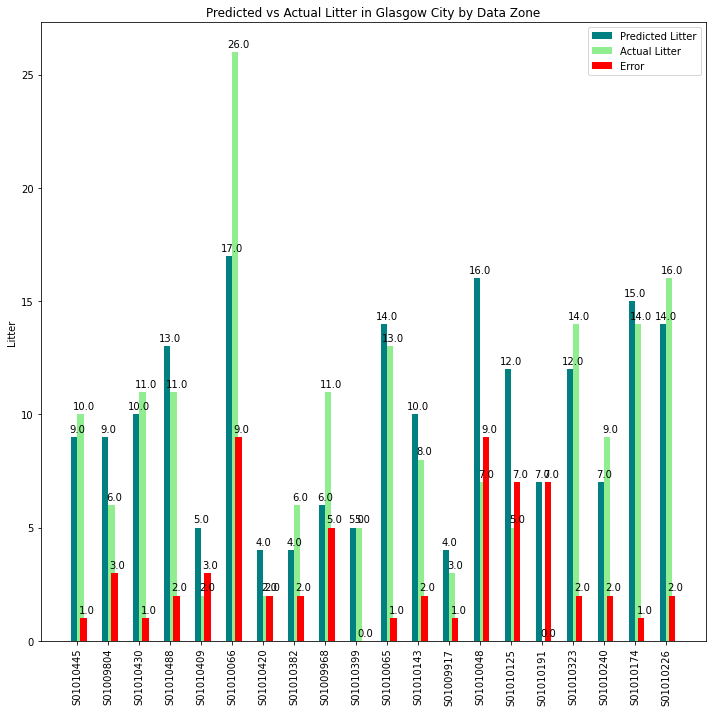

In [121]:
y_test, X_test = dmatrices(nb_model_formula, df_test, return_type="dataframe")
nb_model_test = sm.GLM(y_test, X_test, family=sm.families.NegativeBinomial(alpha=0.4)).fit()
print(nb_model_test.summary())
print("AIC:", nb_model_test.aic)
check_pearson_chi2(pearson_chi2=nb_model_test.pearson_chi2, residuals=nb_model_test.df_resid)
scatter_plot(df_test, nb_model_formula, nb_model_test)
bar_plot(df_test, nb_model_formula, nb_model_test)

In [122]:
reject, corrected_pvalues, _, _ = multipletests(nb_model_test.pvalues, alpha=0.05, method="bonferroni")
print(nb_model_test.pvalues)
print(corrected_pvalues)
print(reject)

Intercept            1.233352e-141
ALCOHOL               5.386816e-01
SMR                   9.103367e-01
Attainment            2.841708e-01
DEPRESS               7.447436e-01
EMERG                 2.286488e-01
employment_rate       8.593410e-01
CIF                   7.687427e-01
Attendance            5.779478e-01
income_rate           8.875770e-01
no_qualifications     5.021705e-03
dtype: float64
[1.35668686e-140 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 5.52387509e-002]
[ True False False False False False False False False False False]
